# Hackday - 1st Place Solution

Nosso objetivo aqui foi desenvolver um modelo de avaliação de aumento de limite de cartão de crédito. O modelo deve informar se o Banco Billion deve "negar" ou "conceder" o aumento do limite do cartão de crédito solicitado pelo cliente.

Nessaa competição o foco principal foi detectar todos os 'dados ruidosos' e qual abordagem deveríamos adotar ao tratar os outliers. As únicas funcionalidades criadas foram baseadas na `agregação de IDs de clientes`. Há muito potencial de melhoria ainda a ser feito. A melhor pontuação foi obtida por um conjunto de `0,51 XGB (300 estimadores) + 0,49 LGBM (1000 estimadores)`.


Por favor, sinta-se à vontade para esclarecer quaisquer dúvidas ou sugestões sobre como podemos melhorar nosso trabalho nos comentários abaixo. Além disso, deixe-nos saber se você gostou do notebook!

# 0.0 Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import gc
# import joblib
import random

# from category_encoders       import TargetEncoder

# import pylab

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.metrics         import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics         import classification_report
from sklearn.model_selection import TimeSeriesSplit, KFold, StratifiedKFold, GroupKFold


from sklearn.preprocessing   import RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression, Ridge
from sklearn.linear_model    import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# from sklearn.neural_network  import MLPClassifier

from sklearn.feature_selection import mutual_info_classif

import optuna


from sklearn.metrics         import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

from colorama                import Fore, Back, Style

import warnings
warnings.filterwarnings("ignore")

C:\Users\Cliente\anaconda3\envs\Hackday\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    color_pal = sns.color_palette()
    plt.style.use('fivethirtyeight')

    sns.set()
jupyter_settings()

    
def make_mi_scores(mi_scores, X, y):
    mi_scores = pd.Series(mi_scores, name="MI Scores")
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores, X):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = X.columns[scores.index]
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    return ticks

def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# 1.0 CFG

In [4]:
class CFG:
    FOLDS = 5
    seed = 10
    TARGET = 'limite_adicional'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed = CFG.seed)

# 2.0 EDA

In [2]:
Essa análise se encontra em : https://github.com/GuilhermeMarquesss/Credit-Card/blob/main/EDA.ipynb

# 3.0 Feature Engineering

## 3.1 Classical Features

In [5]:
rs = RobustScaler()
ss = StandardScaler()
mm = MinMaxScaler()
le = LabelEncoder()

In [6]:
def create_features(df):
    """
    Adds features to dfing or test set.   
    """
    
    ###################################### OUTLIER PROCESSING ######################################
    
#     df['renda_anual'] = df['renda_anual'].apply(lambda x: )    
#     df[out_col] = ss.fit_transform(df[out_col])


    ### FLOAT COLUMNS
    
#     df['saldo_atual'] = df['saldo_atual'].apply(lambda x: x.mean() if x == 337.17 else x)
    df['renda_anual'] = df['renda_anual'].apply(lambda x: (200_000 + 3*38370) if x > 200_000 else x)
    df['valor_em_investimentos'] = df['valor_em_investimentos'].apply(lambda x: 188.50 if x == 10_000 else x)
    
    
#     df['saldo_atual'] = ss.fit_transform(df[['saldo_atual']].values)
#     df['renda_anual'] = ss.fit_transform(df[['renda_anual']].values)
#     df['valor_em_investimentos'] = ss.fit_transform(df[['valor_em_investimentos']].values)
    
    df['taxa_utilizacao_credito'] = ss.fit_transform(df[['taxa_utilizacao_credito']].values)
       
    ### INT COLUMNS
    # Changed outliers for each df[col].median() without them, check EDA session.
    
    df['taxa_juros'] = df['taxa_juros'].apply(lambda x: 13 if x > 40 else x)
    df['num_consultas_credito'] = df['num_consultas_credito'].apply(lambda x: 4 if x > 12 else x)
    df['idade'] = df['idade'].apply(lambda x: 38 if x > 101 else x)
    df['num_cartoes_credito'] = df['num_cartoes_credito'].apply(lambda x: 5 if x > 11 else x)
    df['num_emprestimos'] = df['num_emprestimos'].apply(lambda x: 3 if x >= 100 else x) 
    df['num_contas_bancarias'] = df['num_contas_bancarias'].apply(lambda x: 6 if x > 11 else x)
    df['num_pgtos_atrasados'] = df['num_pgtos_atrasados'].apply(lambda x: 14 if x > 28 else x)   
    
    
    
    ### Contabeis
    
#     df['saldo_ano'] = df['renda_anual'] - df['saldo_atual']
#     df['potencial'] = df['saldo_atual'] / df['divida_atual']
    
    
#     df['niveis_atraso'] = df['dias_atraso_dt_venc'].apply(lambda x: 'Ok'       if x <= 5 else 
#                                                                     'Atrasado' if x <= 30 else
#                                                                     'Inadimplente' if x <= 60 else 'Critico')
    
        

    ###################################### FEATURE ENGINEERING ######################################  
    
    df['investe_exterior'] = df['investe_exterior'].replace(['Não', 'Sim'], [0, 1])
    df['pessoa_polit_exp'] = df['pessoa_polit_exp'].replace(['Não', 'Sim'], [0, 1])
    df['limite_adicional'] = df['limite_adicional'].apply(lambda x: 0 if x == 'Negar' else 1)
    
    
    
#     df['idade_bucket'] = df['idade'].apply(lambda x: "Jovem" if x <= 25 else
#                                                             "Adulto" if x <= 38 else
#                                                              "Coroa" if x < 55 else "Velho")
    
    
#     df['status'] = df['num_cartoes_credito'].apply(lambda x:    'Normal'       if x <= 4 else 
#                                                                 'Rico' if x <= 5 else
#                                                                 'Playboy' if x <= 7 else 'Galatico')
    

    
#     df = pd.get_dummies(df,prefix=['niveis_atraso'], columns=['niveis_atraso'], drop_first=False)
#     df = pd.get_dummies(df,prefix=['status'], columns=['status'], drop_first=False)
#     df = pd.get_dummies(df,prefix=['age'], columns=['idade_bucket'], drop_first=False)


                                                                            
#     df['renda_mensal'] = df['renda_anual'] / 12
#     df['responsabilidade_cliente'] = df.apply(lambda x: 0 if x['renda_mensal'] < x['divida_atual'] else 1, axis = 1)
    

    
    return df


In [8]:
%%time

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
df_sub = test[['id_cliente']].copy()

train['isTrain'] = True
test['isTrain'] = False
tt = pd.concat([train, test]).reset_index(drop=True).copy()
tt = create_features(tt)
train = tt.query('isTrain').reset_index(drop=True).copy()
test = tt.query('isTrain == False').reset_index(drop=True).copy()

CPU times: total: 78.1 ms
Wall time: 123 ms


In [9]:
train.shape, test.shape

((9500, 18), (3000, 18))

## 3.2 Agg Features

### Agg Float Cols Stats

In [10]:
numerical_col = [col for col in train.columns if train[col].dtype == 'float64']
numerical_col

['saldo_atual',
 'divida_atual',
 'renda_anual',
 'valor_em_investimentos',
 'taxa_utilizacao_credito']

In [11]:
train_num_agg = train.groupby("id_cliente")[numerical_col].agg(['mean', 'std', 'min', 'max'])
train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
train_num_agg.head()

,saldo_atual_mean,saldo_atual_std,saldo_atual_min,saldo_atual_max,divida_atual_mean,divida_atual_std,divida_atual_min,divida_atual_max,renda_anual_mean,renda_anual_std,renda_anual_min,renda_anual_max,valor_em_investimentos_mean,valor_em_investimentos_std,valor_em_investimentos_min,valor_em_investimentos_max,taxa_utilizacao_credito_mean,taxa_utilizacao_credito_std,taxa_utilizacao_credito_min,taxa_utilizacao_credito_max
id_cliente,,,,,,,,,,,,,,,,,,,,
1,312.49409,NaN,312.49409,312.49409,809.98000,NaN,809.98000,809.98000,25823.17612,NaN,25823.17612,25823.17612,80.41530,NaN,80.41530,80.41530,-1.07577,NaN,-1.07577,-1.07577
3,1043.31598,NaN,1043.31598,1043.31598,1303.01000,NaN,1303.01000,1303.01000,148459.65768,NaN,148459.65768,148459.65768,168.41370,NaN,168.41370,168.41370,-0.72288,NaN,-0.72288,-0.72288
4,433.60477,NaN,433.60477,433.60477,632.46000,NaN,632.46000,632.46000,41462.04139,NaN,41462.04139,41462.04139,81.22886,NaN,81.22886,81.22886,-1.13052,NaN,-1.13052,-1.13052
7,858.46247,NaN,858.46247,858.46247,352.16000,NaN,352.16000,352.16000,136171.99580,NaN,136171.99580,136171.99580,378.17125,NaN,378.17125,378.17125,-0.01799,NaN,-0.01799,-0.01799
9,802.30044,NaN,802.30044,802.30044,1377.74000,NaN,1377.74000,1377.74000,122417.74506,NaN,122417.74506,122417.74506,215.19352,NaN,215.19352,215.19352,0.26998,NaN,0.26998,0.26998


In [12]:
train.shape, train_num_agg.shape

((9500, 18), (9500, 20))

In [13]:
train_aux = pd.merge(left=train, right=train_num_agg, how='left', on='id_cliente')

In [14]:
train_aux.dropna(axis=1, inplace=True)

In [15]:
test_num_agg = test.groupby("id_cliente")[numerical_col].agg(['mean', 'std', 'min', 'max'])
test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

In [16]:
test_aux = pd.merge(left=test, right=test_num_agg, how='left', on='id_cliente')

In [17]:
test_aux.dropna(axis=1, inplace=True)

In [18]:
train_aux.shape, test_aux.shape

((9500, 33), (3000, 33))

### Agg Categorical Cols

I didnt check it out how these features perform yet, should give them a try.

In [20]:
# train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
# train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]

In [22]:
# train_aux2 = pd.merge(left=train, right=train_cat_agg, how='left', on='id_cliente')

# 4.0 Modeling

I tried Stratified KFold Cross-Validation but my best performance submission was an ensemble of 2 models, LGBM and XGB, without using cross-validation method.

## 4.1 Feature Selection

In [23]:
# X = train.copy()
# y = train['limite_adicional']

X = train_aux.copy()
y = train_aux['limite_adicional']

In [24]:
FEATURES = [
#        'id_cliente',
    'idade', 
    'saldo_atual',
    'divida_atual',
    'renda_anual',
    'valor_em_investimentos', 
    'taxa_utilizacao_credito', 
    'num_emprestimos',
    'num_contas_bancarias', 
    'num_cartoes_credito', 
    'dias_atraso_dt_venc',
    'num_pgtos_atrasados', 
    'num_consultas_credito', 
    'taxa_juros',
    'investe_exterior', 
    'pessoa_polit_exp', 
#        'limite_adicional', 
#        'isTrain',
   'saldo_atual_mean',
    'saldo_atual_min', 
    'saldo_atual_max',
   'divida_atual_mean', 
    'divida_atual_min', 
    'divida_atual_max',
   'renda_anual_mean', 
    'renda_anual_min', 
    'renda_anual_max',
   'valor_em_investimentos_mean', 
    'valor_em_investimentos_min',
   'valor_em_investimentos_max', 
]

TARGET = 'limite_adicional'
ESTIMATORS = 500

n_features = len(FEATURES)

print('Using ...')
print('')
print(f'{n_features:.>5} features.')
print('')

Using ...

...27 features.



## 4.2 First Impressions 

Checking which model performs best with just a simple train/test split of 20% for test_size.

In [25]:
train['limite_adicional'] = train['limite_adicional'].replace(['Negar', 'Conceder'], [0, 1])

In [26]:
X['investe_exterior'] = X['investe_exterior'].replace(['Não', 'Sim'], [0, 1])
X['pessoa_polit_exp'] = X['pessoa_polit_exp'].replace(['Não', 'Sim'], [0, 1])
X['limite_adicional'] = X['limite_adicional'].replace(['Negar', 'Conceder'], [0, 1])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X[FEATURES], y, stratify = y, test_size=.2, random_state=CFG.seed)

In [28]:
X.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional,isTrain,saldo_atual_mean,saldo_atual_min,saldo_atual_max,divida_atual_mean,divida_atual_min,divida_atual_max,renda_anual_mean,renda_anual_min,renda_anual_max,valor_em_investimentos_mean,valor_em_investimentos_min,valor_em_investimentos_max,taxa_utilizacao_credito_mean,taxa_utilizacao_credito_min,taxa_utilizacao_credito_max
0,1767,21,278.17201,2577.05000,24196.89636,104.30654,-0.24649,6,5,7,21,14,9,15,0,0,0,True,278.17201,278.17201,278.17201,2577.05000,2577.05000,2577.05000,24196.89636,24196.89636,24196.89636,104.30654,104.30654,104.30654,-0.24649,-0.24649,-0.24649
1,11920,40,268.87415,2465.39000,19227.37796,69.85878,0.90972,5,8,5,40,23,10,18,0,0,0,True,268.87415,268.87415,268.87415,2465.39000,2465.39000,2465.39000,19227.37796,19227.37796,19227.37796,69.85878,69.85878,69.85878,0.90972,0.90972,0.90972
2,8910,36,446.64313,1055.29000,42822.28223,134.20148,0.44644,0,3,6,26,13,3,15,1,0,0,True,446.64313,446.64313,446.64313,1055.29000,1055.29000,1055.29000,42822.28223,42822.28223,42822.28223,134.20148,134.20148,134.20148,0.44644,0.44644,0.44644
3,4964,58,321.14127,703.05000,51786.82600,297.35007,-0.15704,0,3,7,12,7,2,1,1,0,0,True,321.14127,321.14127,321.14127,703.05000,703.05000,703.05000,51786.82600,51786.82600,51786.82600,297.35007,297.35007,297.35007,-0.15704,-0.15704,-0.15704
4,10100,35,428.71611,891.29000,44626.85346,134.20148,-0.83850,2,8,7,24,10,8,20,1,0,0,True,428.71611,428.71611,428.71611,891.29000,891.29000,891.29000,44626.85346,44626.85346,44626.85346,134.20148,134.20148,134.20148,-0.83850,-0.83850,-0.83850


In [29]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: limite_adicional, dtype: int64

In [30]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

score    = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred, average='weighted')
acc      = accuracy_score(y_test, y_pred)


print(f'')
print(f'Average Accuracy = {acc:.5f}' )
print(f'Average AUC = {score:.5f}')
print(f'Average F1-Score = {f1:.5f}')


Average Accuracy = 0.84737
Average AUC = 0.61536
Average F1-Score = 0.82627


In [31]:
model_xgb = xgb.XGBClassifier(n_estimators=200)

model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

score    = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred, average='weighted')
acc      = accuracy_score(y_test, y_pred)


print(f'')
print(f'Average Accuracy = {acc:.5f}' )
print(f'Average AUC = {score:.5f}')
print(f'Average F1-Score = {f1:.5f}')


Average Accuracy = 0.86789
Average AUC = 0.72195
Average F1-Score = 0.86347


In [32]:
model_lgbm = lgbm.LGBMClassifier(n_estimators=200)

model_lgbm.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

score    = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred, average='weighted')
acc      = accuracy_score(y_test, y_pred)


print(f'')
print(f'Average Accuracy = {acc:.5f}' )
print(f'Average AUC = {score:.5f}')
print(f'Average F1-Score = {f1:.5f}')


Average Accuracy = 0.84737
Average AUC = 0.61536
Average F1-Score = 0.82627


In [33]:
model_cat = cb.CatBoostClassifier(iterations=200)

model_cat.fit(X_train, y_train, verbose=False)
y_pred = model_cat.predict(X_test)

score    = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred, average='weighted')
acc      = accuracy_score(y_test, y_pred)


print(f'')
print(f'Average Accuracy = {acc:.5f}' )
print(f'Average AUC = {score:.5f}')
print(f'Average F1-Score = {f1:.5f}')


Average Accuracy = 0.87895
Average AUC = 0.73660
Average F1-Score = 0.87399


In [34]:
model_rf = RandomForestClassifier()

model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

score    = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred, average='weighted')
acc      = accuracy_score(y_test, y_pred)


print(f'')
print(f'Average Accuracy = {acc:.5f}' )
print(f'Average AUC = {score:.5f}')
print(f'Average F1-Score = {f1:.5f}')


Average Accuracy = 0.87632
Average AUC = 0.71212
Average F1-Score = 0.86799


## 4.3 XGB

In [35]:
%%time

f1s = []
aucs = []
preds_test = []
importances = []

# using StratifiedKFold cause data is imbalanced
kf = StratifiedKFold(n_splits=CFG.FOLDS, shuffle=True, random_state=CFG.seed)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X[FEATURES], X[TARGET])):
    print('Fold:', fold)
    
    # split train/val
    X_tr = X.loc[tr_idx, FEATURES]
    y_tr = X.loc[tr_idx, TARGET]
    X_va = X.loc[val_idx, FEATURES]
    y_va = X.loc[val_idx, TARGET]
    

    # MODEL
    model_xgb = xgb.XGBClassifier(
        reg_lambda= 0.7103261259878902, 
         alpha= 3.818812772685153, 
         colsample_bytree= 0.8, 
         subsample= 0.75, 
         learning_rate= 0.008, 
         n_estimators= 1000, 
         max_depth= 12, 
         min_child_weight= 7,
        n_jobs=-1
    )

    
    model_xgb.fit(X_tr, y_tr)
                                    
    # Validate model
    va_preds = model_xgb.predict_proba(X_va)[:, 1]
    vaf1_preds = model_xgb.predict(X_va)
    score    = roc_auc_score(y_va, va_preds)
    f1       = f1_score(y_va, vaf1_preds, average='weighted')
    print(f"AUC = {score:.5f} F1-Score: {f1:.5f}")
    aucs.append(score)
    f1s.append(f1)
    
    # Test set predictions
    preds_test.append(model_xgb.predict(test_aux[FEATURES]))
    df_sub[f'fold_{fold}'] = preds_test[fold]
    
    # Feature Importances
    importances.append(model_xgb.feature_importances_)
    
    
    ### free memory
#     del X_tr, y_tr
#     del X_va, y_va
    gc.collect()

    
    
print(f'\nAverage AUC = {sum(aucs) / len(aucs):.5f}')
print(f'Average F1-Score = {sum(f1s) / len(f1s):.5f}' )
print('')
preds_xgb = sum(preds_test)/len(preds_test)

Fold: 0
AUC = 0.91195 F1-Score: 0.87184
Fold: 1
AUC = 0.93922 F1-Score: 0.87584
Fold: 2
AUC = 0.93061 F1-Score: 0.87927
Fold: 3
AUC = 0.93004 F1-Score: 0.87504
Fold: 4
AUC = 0.92213 F1-Score: 0.86427

Average AUC = 0.92679
Average F1-Score = 0.87325

CPU times: total: 2min 5s
Wall time: 1min 30s


In [36]:
fpr, tpr, thresholds = roc_curve(y_va, va_preds)

In [37]:
np.mean(thresholds)

0.41289377

Average AUC = 0.92679
Average F1-Score = 0.87325


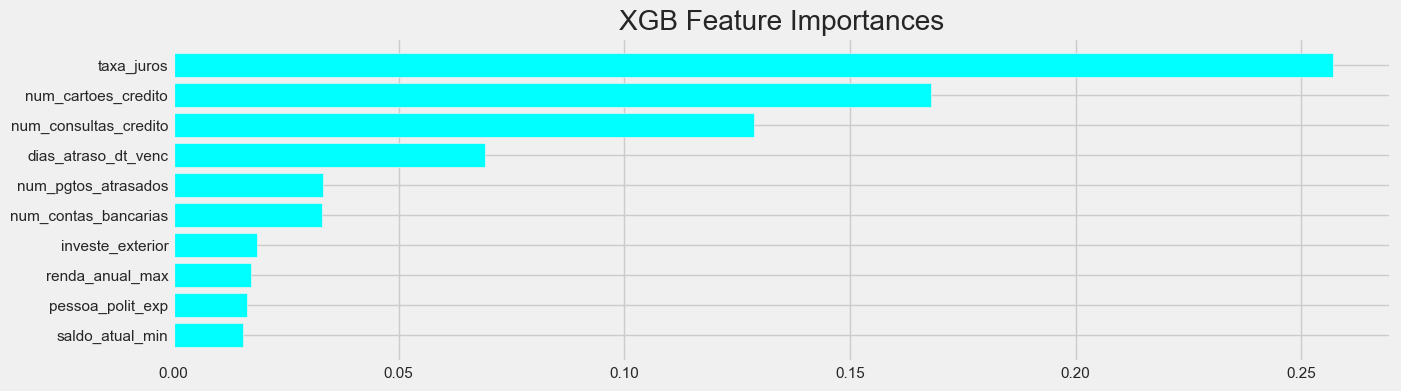

In [38]:
print(f"{Fore.CYAN}{Style.BRIGHT}Average AUC = {sum(aucs) / len(aucs):.5f}\nAverage F1-Score = {sum(f1s) / len(f1s):.5f}{Style.RESET_ALL}")

if type(model_xgb).__name__ == 'XGBClassifier':
    # Show feature importances
    importance_df = pd.DataFrame(np.array(importances).T, index=FEATURES)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = FEATURES
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(10)
    plt.figure(figsize=(14, 4))
    plt.barh(importance_df.index, importance_df['mean'], color='cyan')
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title('XGB Feature Importances')
    plt.show()
# else:
#     importance_df = pd.DataFrame(np.array(importances).T, index=FEATURES)
#     importance_df['mean'] = importance_df.mean(axis=1).abs()
#     importance_df['feature'] = FEATURES
#     importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(15)
#     plt.figure(figsize=(14, 4))
#     plt.barh(importance_df.index, importance_df['mean'], color='cyan')
#     plt.gca().invert_yaxis()
#     plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
#     plt.title('Feature Importances')
#     plt.show()

### 4.3.1 Optuna - XGB

In [39]:
# def objective(trial):
    
#     train_x, test_x, train_y, test_y = train_test_split(X[FEATURES], y, test_size=0.20,random_state=42)
#     param = {
# #         'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02, 0.03, 0.05, 0.08]),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
#         'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
# #         'random_state': trial.suggest_categorical('random_state', [2020]),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
#     }
#     model = xgb.XGBClassifier(**param)  
    
#     model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
# #     preds = model.predict(test_x)
    
#     scores = cross_val_score(model, X[FEATURES], y,
#                               cv=5,
#                               scoring='f1_weighted')

#     scores_mean = scores.mean()
                  
#     print(f'F1 Score Average: {scores_mean}' )
                  
#     return scores_mean


# study = optuna.create_study(direction='maximize')
# study.optimize(objective,n_trials=30);

# trial = study.best_trial

# print('Best F1 Score: {}'.format(trial.value))
# print('Best hyperparam: {}'.format(trial.params))

In [40]:
"""F1 Score Average: 0.8656694532551846
Best F1 Score: 0.8685818878787952
Best hyperparam: {'lambda': 0.7103261259878902, 
                  'alpha': 3.818812772685153, 
                  'colsample_bytree': 0.8, 
                  'subsample': 0.6, 
                   'learning_rate': 0.008, 
                   'n_estimators': 2085, 
                   'max_depth': 17, 
                   'min_child_weight': 7}"""

"F1 Score Average: 0.8656694532551846\nBest F1 Score: 0.8685818878787952\nBest hyperparam: {'lambda': 0.7103261259878902, \n                  'alpha': 3.818812772685153, \n                  'colsample_bytree': 0.8, \n                  'subsample': 0.6, \n                   'learning_rate': 0.008, \n                   'n_estimators': 2085, \n                   'max_depth': 17, \n                   'min_child_weight': 7}"

## 4.4 LGBM

In [41]:
%%time

f1s = []
aucs = []
preds_test = []
importances = []
oof_pred = []; oof_tar = []; oof_names = []; oof_folds = [] 
kf = StratifiedKFold(n_splits=CFG.FOLDS, shuffle=True, random_state=CFG.seed)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X[FEATURES], X[TARGET])):
    print('Fold:', fold)
    
    # split train/val
    X_tr = X.loc[tr_idx, FEATURES]
    y_tr = X.loc[tr_idx, TARGET]
    X_va = X.loc[val_idx, FEATURES]
    y_va = X.loc[val_idx, TARGET]
    

    # MODEL
    model_lgb = lgbm.LGBMClassifier(
                reg_lambda= 1.6626804101540482, 
                  alpha= 0.29793371309642636, 
                  colsample_bytree= 0.9, 
                  subsample= 0.7, 
                  learning_rate= 0.15, 
                  n_estimators= 200, 
                  max_depth= 17,
                  num_leaves=100,
                  min_child_weight= 49,
                n_jobs=-1
    )

    
    model_lgb.fit(X_tr, y_tr)
                                    
    # Validate model
    va_preds = model_lgb.predict_proba(X_va)[:, 1]
    vaf1_preds = model_lgb.predict(X_va)
    score    = roc_auc_score(y_va, va_preds)
    f1       = f1_score(y_va, vaf1_preds, average='weighted')
    print(f"AUC = {score:.5f} F1-Score: {f1:.5f}") # , C = {model.get_params['C']}, penalty = {model.get_params['penalty']}
    aucs.append(score)
    f1s.append(f1)
    
    # Test set predictions
#     preds_test.append(model.predict_proba(test[FEATURES])[:, 1])
    preds_test.append(model_lgb.predict(test_aux[FEATURES]))
    df_sub[f'fold_{fold}'] = preds_test[fold]
    
    
    # Feature Importances
    importances.append(model_lgb.feature_importances_)
    
    
    ### free memory
#     del X_tr, y_tr
#     del X_va, y_va
    gc.collect()

    
    
print(f'\nAverage AUC = {sum(aucs) / len(aucs):.5f}')
print(f'Average F1-Score = {sum(f1s) / len(f1s):.5f}' )
print('')
preds_lgb = sum(preds_test)/len(preds_test)

Fold: 0
AUC = 0.90233 F1-Score: 0.86476
Fold: 1
AUC = 0.93618 F1-Score: 0.88632
Fold: 2
AUC = 0.92394 F1-Score: 0.88268
Fold: 3
AUC = 0.92624 F1-Score: 0.86953
Fold: 4
AUC = 0.91881 F1-Score: 0.86347

Average AUC = 0.92150
Average F1-Score = 0.87335

CPU times: total: 3.3 s
Wall time: 2.25 s


In [42]:
fpr, tpr, thresholds = roc_curve(y_va, va_preds)

In [43]:
np.mean(thresholds)

0.4287410748288226

## 4.5 Feature Importances

Average AUC = 0.92150
Average F1-Score = 0.87335


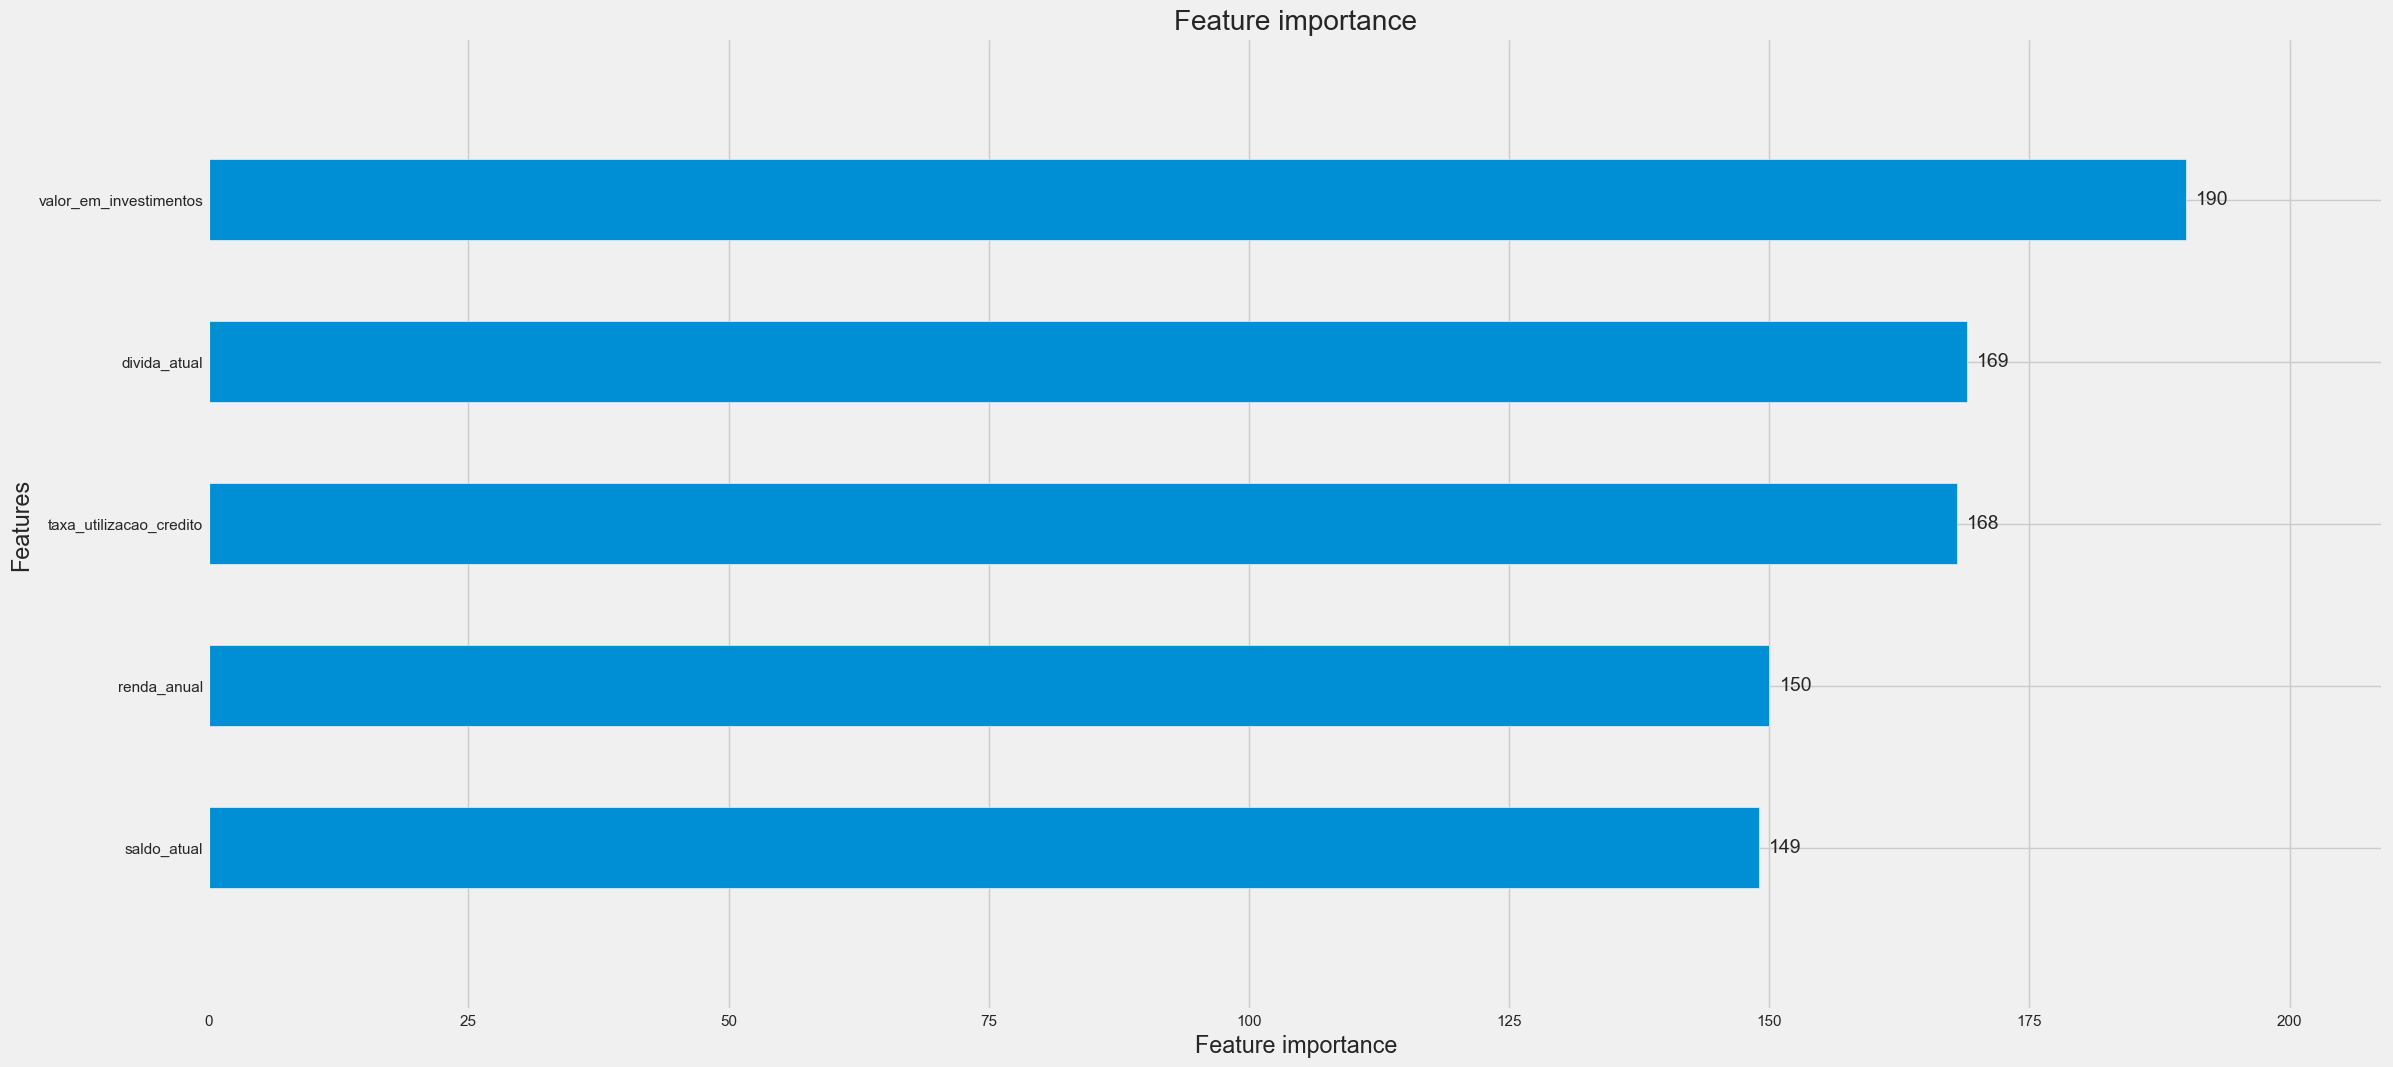

In [44]:
print(f"{Fore.CYAN}{Style.BRIGHT}Average AUC = {sum(aucs) / len(aucs):.5f}\nAverage F1-Score = {sum(f1s) / len(f1s):.5f}{Style.RESET_ALL}")

if type(model_lgb).__name__ == 'LGBMClassifier':
    lgbm.plot_importance(model_lgb, max_num_features = 5, height=.5)
else:
    importance_df = pd.DataFrame(np.array(importances).T, index=FEATURES)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = FEATURES
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(5)
    plt.figure(figsize=(14, 4))
    plt.barh(importance_df.index, importance_df['mean'], color='cyan')
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title('LGBM Feature Importances')
    plt.show()

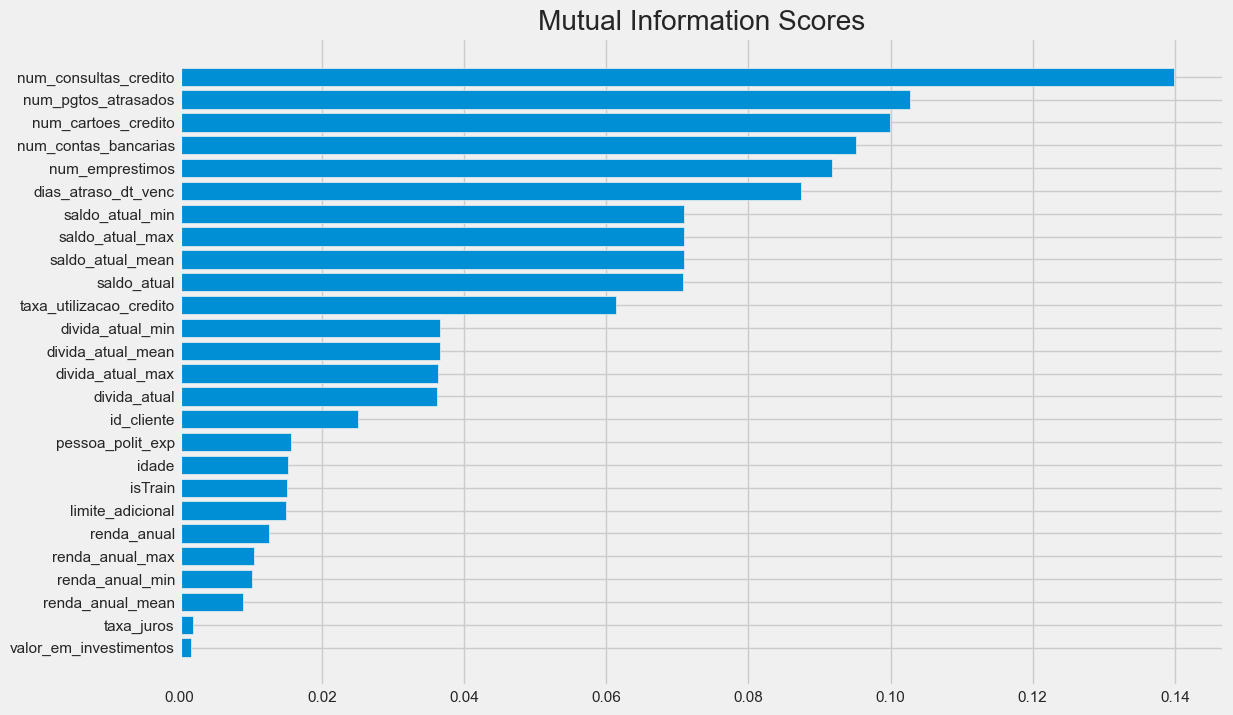

In [45]:
mi_scores = mutual_info_classif(X[FEATURES], y)
mi_scores_classif = make_mi_scores(mi_scores, X[FEATURES], y)

plt.figure(dpi=100, figsize=(12, 8))
columns = plot_mi_scores(mi_scores_classif[mi_scores_classif > 1e-3], X)

# 5.0 Ensembling Models

Tried a different approach from KFold Cross-Validation and it seems to have worked out :)

In [46]:
# INSERIR MANUALMENTE!
MODEL_INFO = 'XGB_LGBM_ensemble_02_featAgg'

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X[FEATURES], y, test_size=.2)

In [48]:
xgb_model = xgb.XGBClassifier(n_estimators=300)
xgb_model.fit(X_train[FEATURES], y_train,
            eval_set=[(X_train[FEATURES],y_train)\
                      ,(X_val[FEATURES], y_val)],
            early_stopping_rounds=25,
           verbose=False)
predictions = xgb_model.predict(X_val[FEATURES])

X_val['predictions'] = predictions
f1_score(y_val,X_val.predictions, average='weighted')

0.8647097328120505

In [49]:
lgb_model = lgbm.LGBMClassifier(n_estimators=1000)
lgb_model.fit(X_train[FEATURES], y_train,
        eval_set=[(X_train[FEATURES],y_train)\
                  ,(X_val[FEATURES], y_val)],
        early_stopping_rounds=25,verbose=False)

X_val['predictions'] = lgb_model.predict(X_val[FEATURES])
f1_score(y_val,X_val.predictions, average='weighted')

0.8668923282195832

In [50]:
predictions1 = lgb_model.predict(test_aux[FEATURES])
predictions2 = xgb_model.predict(test_aux[FEATURES])

predictions = (predictions1*0.49)+(predictions2*(0.51))

# 6.0 Submission

In [51]:
df_sub['limite_adicional'] = predictions

In [52]:
df_sub['limite_adicional'] = df_sub['limite_adicional'].apply(lambda x: 0 if x < 0.5 else 1)

In [53]:
df_sub['limite_adicional'] = df_sub['limite_adicional'].replace([0, 1], ['Negar', 'Conceder'])

In [54]:
df_sub[['id_cliente', 'limite_adicional']].head()

,id_cliente,limite_adicional
0,2,Conceder
1,5,Negar
2,6,Negar
3,8,Negar
4,10,Conceder


In [55]:
# df_sub[['id_cliente', 'limite_adicional']].to_csv(f'sub_{MODEL_INFO}.csv', index=False)
df_sub[['id_cliente', 'limite_adicional']].to_csv('submission.csv', index=False)

In [56]:
df_sub[TARGET].value_counts()

Negar       2605
Conceder     395
Name: limite_adicional, dtype: int64